# **Project 2:** Statistical Learning with the MNIST data set
# **Name: Sanaz Hami Hassan Kiyadeh, shkiyadeh@crinson.ua.edu**
**Due Date: 5pm, Wednesday November 23**

# The MNIST Database

The [MNIST](https://en.wikipedia.org/wiki/MNIST_database) data set contains a collection of $n=60,000$ training images stored as $28\times 28$ grayscale images. Each image is stored as a $p=784$-dimensional vector.
Each of these images correspond to a single handwritten digit ($0,1,2,3,\dots, 8,9$). A smaller subset of the MNIST collection containing only images digits $0$ and $1$ (and each image stored as a $p = 784 = 28\times 28$ dimensional vector in a row of a table) is contained in the given file **mnist01-train.csv**.

We'll experiment with some data visualization and dimension tools to inspect this data, and then perform machine learning to obtain classifiers for predicting whether an image contains the digit $0$ or $1$.

# Reading the data set

The partial data set is contained in the file **mnist01-train.csv**. 

Let's use **numpy** to read its contents into an array.

In [2]:
from google.colab import files
files=files.upload()

Saving mnist01-test.csv to mnist01-test (1).csv
Saving mnist01-train.csv to mnist01-train.csv
Saving projectHelpers.py to projectHelpers.py


In [3]:
# Imports.
import numpy as np

M = np.genfromtxt("mnist01-train.csv", delimiter=",", skip_header= True)

# Confirm read completed.
n, p = M.shape
print("Created MNIST array with %g rows (images) and %g columns (labels and pixel intensities)" %(n, p))

Created MNIST array with 12665 rows (images) and 785 columns (labels and pixel intensities)


The first column in the array/matrix $M$ stores the labels ($0$ or $1$) of each row/image. The remaining columns store the pixel intensities of each $28\times 28$ image, reshaped as a $784$-dimensional vector.

We can isolate the labels and images as their own arrays.

In [4]:
# Split labels and images.
y = M[:,0] # labels.
X = M[:, 1:] # data matrix with images as row.

Let's view one of the images (say the one in the $i=0$ row):

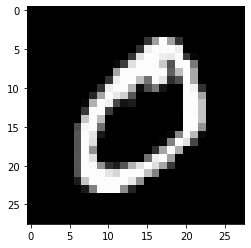

In [5]:
# Import pyplot.
import matplotlib.pyplot as plt

# Plot image using reshape and imshow.
plt.imshow(X[0,:].reshape(28,28), cmap = "gray")
plt.show()

Let's plot a representative image of the digit $1$ (e.g., the image stored in the last data row):

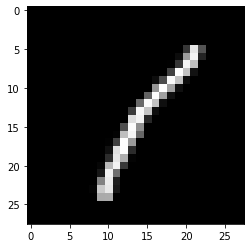

In [6]:
plt.imshow(X[-1,:].reshape(28,28), cmap = "gray")
plt.show()

There are many pixels that are blank in almost all of the images. Let's delete the columns of $X$ corresponding to these pixels. After doing so, we can delete $M$ to save memory.

In [7]:
# Delete mostly zero columns.
col_sum = np.sum(X, axis = 0)
idx = col_sum >= 600

X = X[:, idx]

# Confirm X is the right size.
n, p = X.shape
print("Created reduced MNIST array with %g rows (images) and %g columns (only pixel intensities)" %(n, p))

# Delete M.
del M

Created reduced MNIST array with 12665 rows (images) and 491 columns (only pixel intensities)


# Principal Component Analysis

We will use **principal component analysis (PCA)** to help visualize the data and reduce complexity of our later models. 

PCA performs a linear transformation to a new coordinate system, i.e., change of basis, where most variation in the data can be explain using variation in the direction of the first few coordinate vectors. This is achieved by taking the SVD of the data matrix (equivalently, the eigendecomposition of the data covariance matrix) to obtain the **principal component vector** or **principal components** and using these to form an orthonormal basis for the representation of the data in the new coordinate system.

More details about PCA can be found in this [wiki](https://en.wikipedia.org/wiki/Principal_component_analysis#Network_component_analysis)
and in Section 12.2 of the book [Introduction to Statistical Learning](https://www.statlearning.com).

## Dimension Reduction and Visualization using PCA

One of the primary advantages of PCA is that it facilitates **dimension reduction**: if many/most of the principal component directions correspond to direction in which the data exhibits relatively meaningful variation then we can omit these directions from the data set. This allows us to approximate the actual data using a sparse representation using only a small number of principal components.

This is especially helpful when trying to visualize high-dimensional data. For example, the observations in the MNIST data are stored as $491$-dimensional vectors; we are unable to meaningful plot the full data set since we cannot visualize elements of $\mathbf{R}^{491}$.
However, if we project the data set onto the span of the first two principal components, then we can approximate each image vector using two values: the coefficients of the first and second principal components in the PC basis expansion. 

More specifically, let's suppose that the principal components are $\{v_1, v_2, \dots, v_p\}$ and $x \in \mathbf{R}^p$ can be written as 
$$
    x = V z = z_1 v_1 + z_2 v_2 + \cdots + z_p v_p
$$
using the basis of principal component vectors. Then we can associate $x$ with the vector $z$ and plot the 2D approximation $(z_1, z_2)$ in the plane.

If the *full* data set is stored in the rows of $X$ (columns of $X^T$ then we can project *every* record onto the span of $v_1$ and $v_2$ using
$$
    Z^T = V_{0:1}^T X^T \hspace{0.25in} Z = X V_{0:1},
$$
where $V_{0:1}$ is the $p\times 2$ dimensional vector storing the first two principal components and $Z$ is a $n \times 2$ reduced data matrix where each row stores the 2D representation of the corresponding image. After performing this dimension reduction, we can make a scatter plot of the rows of $Z$ to visualize the data in the plane.


## Computing the PCA of the MNIST Data

We can use the **getPCs** function from the **projectHelpers** module to calculate $k$ leading principal components for a given $k$.



In [8]:
# Import helper functions from module.
import projectHelpers as ph

Here, we'll use $k = 2$ to get the first two principal component vectors of the MNIST data set.

In [9]:
# Get first 2 principal componenents.
V = ph.getPCs(X, 2)

This gives the matrix $V \in \mathbf{R}^{p\times 2}$ with columns storing the first two principal components.

We can project/map $X$ onto the two-dimensional PC space (i.e., the span of the first two PCs), using the product 
$$ Z = X V \in \mathbf{R}^{n\times 2} $$

In [10]:
# Project onto the PC space.
Z = X.dot(V)

We can make a scatterplot the representation of the data in the PC set using the following code:

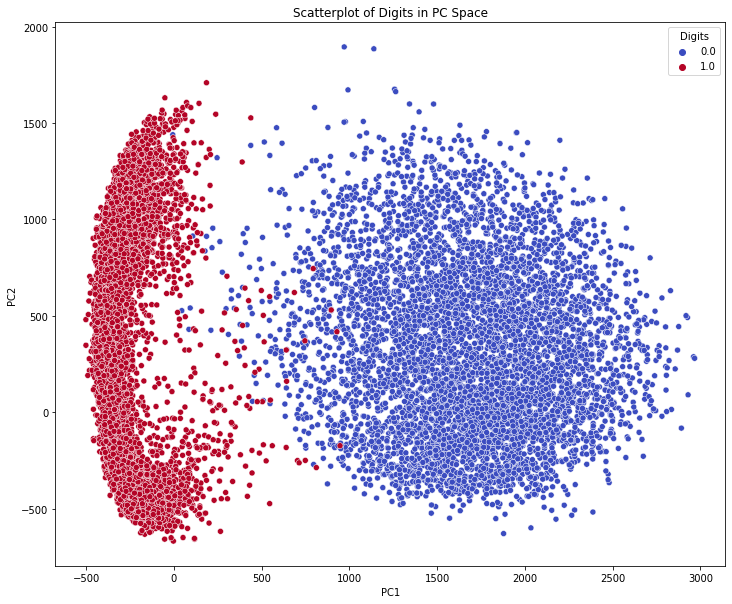

In [11]:
# Import seaborn and pandas.
import seaborn as sns
import pandas as pd

# Create dictionary/data frame storing the data in the PC space (with labels).
data = {"x": Z[:,0],
        "y": Z[:,1],
        "Digits": y}

df = pd.DataFrame(data)

plt.figure(figsize=(12,10))
sns.scatterplot(data = df, x = "x", y = "y", 
                hue="Digits",
                hue_norm=(0,1),
                markers = "Digits",
                palette="coolwarm")
plt.title("Scatterplot of Digits in PC Space")                
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Binary Classification

In a **binary** or **boolean classification** problem, we want to learn model parameters for an unknown function $f$ which maps to the discrete set $\{0,1\}$, where the values $\{0,1\}$ correspond to the **labels** or **response** variable values:
$$
    f(x) \approx y.
$$
The goal is to identify the function $f$ (called a **classifier**) such that the number of disagreements between the actual label $y_i$ and the predicted label $f(x_i)$ is minimized.

This is an example of **supervised learning**: we want to use the given data and corresponding labels (called **training data**) to *learn* a rule for assigning labels; this is supervised because we have used the actual labels for the training set to help train this rule.

## Least Squares Classifiers

One of the simplest (yet often surprisingly effective) methods for binary classification relies on a modification of least squares linear regression. 

To do so, we fit a linear model $$\beta^T x_i + v \approx y_i$$ where $x_i \in \mathbf{R}^p, y_i \in \{-1,1\}$ are the $i$-th data vector and the corresponding response value using least squares regression. (We used the notation $a_i, b_i, x$ for the data vector, response value, and model coefficients in Lab 6 instead of $x_i, y_i, (\beta, v)$.) 

After finding the choice of $\beta$ minimizing the least squares error function, we then make our prediction of what class an observation $x$ belongs to using the classifier
$$
    f(x) = \text{sign}(\beta^T x + v);
$$
that is, $x$ belongs to the class with label $-1$ if $f(x) = -1$, and the class with label $+1$ otherwise.

Note that this requires that we use the class labels $\{-1, 1\}$ (instead of $\{0,1\}$ as above).

## Training a Least Squares Classifier for MNIST

In this section, we'll train least squares classifiers for the reduced MNIST data set.

To do so, we'll use the function **lsRegression** from the **projectHelpers** module, which performs least squares linear regression for a given training data set.

## **Problem 1**

Use the function **lsRegression** to train two linear regression models for the MNIST data set:

* One using the full data set (stored in the array **X**):
$$ y_i \approx x_i^T \beta + v. $$

* Another using the projection of the data set onto the two-dimensional PC space (i.e., projection onto the two leading principal components).  This data is stored in the array **Z**:
$$ y_i \approx z_i^T \hat \beta + \hat v. $$

**Hint:** You will need to transform the labels $y$ (currently stored as a $\{0,1\}$-vector) to obtain a label vector using $\{-1, 1\}$-vector. You can then use these new labels as response/right-hand side when calculating your linear regression models.

In [12]:
y_s=y.copy()
for i in range(len(y_s)):
  if y_s[i]==0:
    y_s[i]=-1

In [13]:
beta_X,v_X=ph.lsRegression(X,y_s)

In [14]:
beta_Z,v_Z=ph.lsRegression(Z,y_s)

# Validating the Models with Training Data

To determine how well the least squares classifier (LSC) predicts digits, we should use each LSC to predict the label/digit of each image and then compare to actual labels.

To do so, we'll use the function **lscPreds** from the **projectHelpers** module, which returns the predicted labels (as a $\{-1,1\}$-vector) and the predicted values of the linear model $X\beta + v$ for given data matrix $X$ and linear model cofficients and intercept $(\beta, v)$.

## **Problem 2**

### **Part a**

Use **lscPreds** to predict the digit of each image in the MNIST training set using the two least squares regression models calculated above. Predict the digit for each image using ...

* The formula $f_1(x_i) = \text{sign}(x_i^T \beta + v)$, and

* The formula $f_2(z_i) = \text{sign}(z_i^T \hat\beta + \hat v)$.

In [15]:
f_1,y_1=ph.lscPreds(X,beta_X,v_X)
f_2,y_2=ph.lscPreds(Z,beta_Z,v_Z)

### **Part b:** Scatterplots of Predicted Digits

Make scatter plots of the training data in the two-dimensional PC space using the actual labels to assign marker shapes and the predicted labels given by:

*  the predicted labels using the least squares classifier calculated using $X$.

*  the predicted labels using the least squares classifier calculated using $Z$.

This will yield two scatterplots. In both cases, you will plot the coordinates in the plane of each image after mapping to the PC space (i.e., $Z$).

**Hints:**

* For both plots, you will plot the coordinates in the plane of each image after mapping to the PC space (i.e., the corresponding row of $Z$). The only difference in the code to make the scatter plot should be the vector used to assign color labels to the points.

* You can modify the code for generating the scatter plot of the data in the PC space used above. You'll need to change the construction of the data frame to include both the predicted and actual labels, and change the call to **scatterplot** to use these for color and marker labels.

* You'll need to transform the $\{-1,1\}$ labels to obtain $\{0,1\}$ digit labels.

In [16]:
#transfrming -1,1 labels to 0,1:
for i in range(len(f_1)):
  if f_1[i]==-1:
    f_1[i]=0
  if f_2[i]==-1:
    f_2[i]=0  

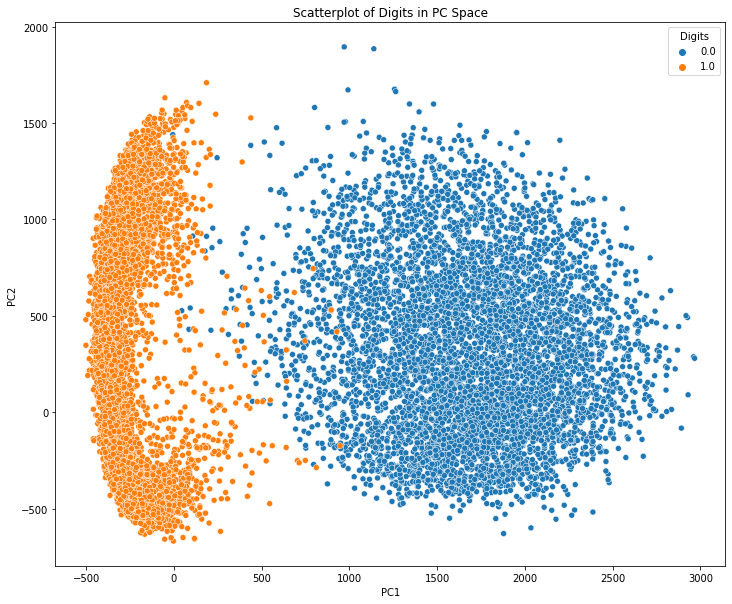

In [17]:
import matplotlib.pyplot as plt
# Import seaborn and pandas.
import seaborn as sns
import pandas as pd

# Create dictionary/data frame storing the data in the PC space (with labels).
data = {"x": Z[:,0],
        "y": Z[:,1],
        "Digits": y}

df = pd.DataFrame(data)

plt.figure(figsize=(12,10))
sns.scatterplot(data = df, x = "x", y = "y", 
                hue="Digits")
plt.title("Scatterplot of Digits in PC Space")                
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

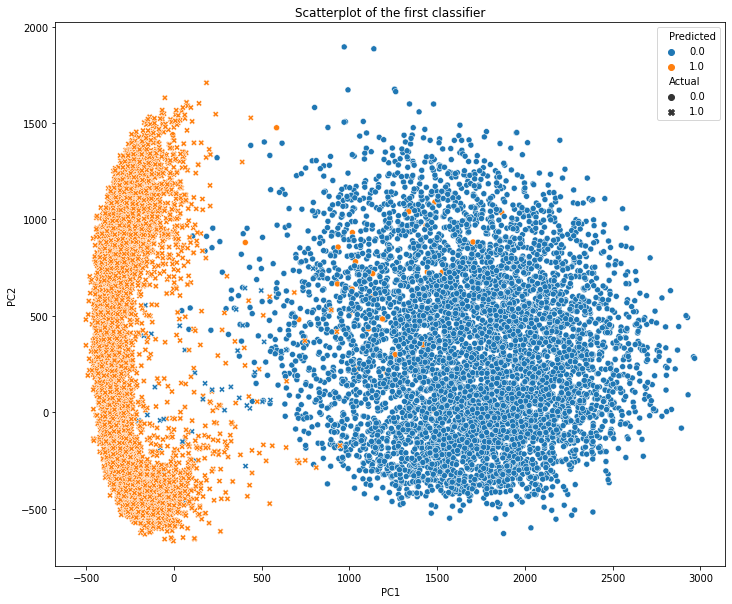

In [18]:
import matplotlib.pyplot as plt
# Import seaborn and pandas.
import seaborn as sns
import pandas as pd

# Create dictionary/data frame storing the data in the PC space (with labels).
data = {"x": Z[:,0],
        "y": Z[:,1],
        "Actual": y,
        "Predicted":f_1}

df = pd.DataFrame(data)
plt.figure(figsize=(12,10))
sns.scatterplot(data = df, x = "x", y = "y", 
                hue="Predicted",style="Actual")
plt.title("Scatterplot of the first classifier")                
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

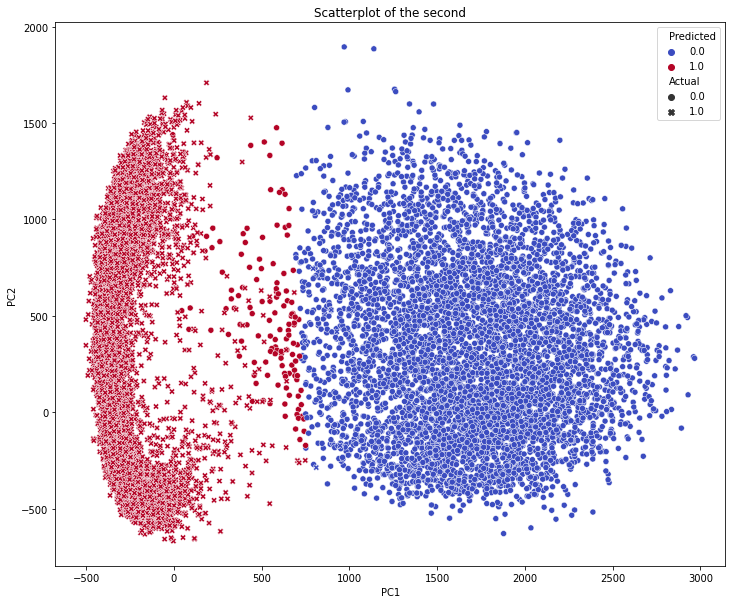

In [19]:
# Import seaborn and pandas.
import seaborn as sns
import pandas as pd

# Create dictionary/data frame storing the data in the PC space (with labels).
data = {"x": Z[:,0],
        "y": Z[:,1],
        "Predicted": f_2,
        "Actual":y}

df = pd.DataFrame(data)

plt.figure(figsize=(12,10))
sns.scatterplot(data = df, x = "x", y = "y", 
                hue="Predicted",
                hue_norm=(0,1),
                style = "Actual",
                palette="coolwarm")
plt.title("Scatterplot of the second")                
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

### **Part c:** Confusion Matrices

A **confusion matrix** for a binary classification is a $2\times 2$ matrix with rows corresponding to predicted labels and columns collecting the actual labels. 

Specifically, the $(i,j)$-th entry of a confusion matrix is the number of data items predicted to have **Label i** that actually have **Label j**. If the classifier is accurately labeling data, then most of the off-diagonal entries of the confusion matrix should be close to $0$.

**Assignment** 

* Write a program for calculating the confusion matrix corresponding to a set of predicted class labels (stored in array **preds**) and actual class labels (stored in **actual**).

* Use this program to calculate the confusion matrix for the predicted labels for the training set given by the classifiers $f_1$ and $f_2$, and the actual digit labels $y$. 

* Use the **heatmap** function in **seaborn** to plot these two confusion matrices. Use the keyword argument **annot** to include the matrix values in each of the heatmap cells.

* Calculate the total number of correctly/incorrectly labeled digits for each classifier $f_1$,$f_2$ and report these totals and the $\%$ of correctly identified digits in the training set.

**Hints:**

* You can recycle the code using **heatmap** to visualize matrices in Lab 8.

* Review the  [documentation](https://seaborn.pydata.org/generated/seaborn.heatmap.html) for the **heatmap** function for further usage details.




In [20]:
#making the confusion matrix

def conf(preds,actual):
  M=np.zeros((2,2))
  for i in range(2):
    for j in range(2):
      for k in range(len(preds)):
        if (preds[k]==i and actual[k]==j):
          M[i,j]+=1
  return M


  

In [21]:
conf1=conf(f_1,y)
conf2=conf(f_2,y)


[Text(83.40000000000006, 0.5, 'Predicted labels'),
 Text(0.5, 15.0, 'Actual labels')]

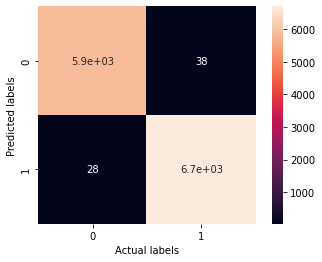

In [22]:
from seaborn import heatmap
s=heatmap(conf1,square=True, cbar=True,annot=True)
s.set(xlabel='Actual labels', ylabel='Predicted labels')


[Text(83.40000000000006, 0.5, 'Predicted labels'),
 Text(0.5, 15.0, 'Actual labels')]

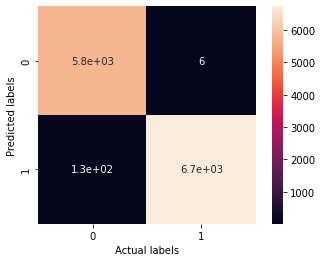

In [23]:
from seaborn import heatmap
s=heatmap(conf2,square=True, cbar=True,annot=True)
s.set(xlabel='Actual labels', ylabel='Predicted labels')

In [24]:
print("The first classifier predits the label of %1.0f items correctly which consists %1.3f percent of the training data." %( conf1[0,0]+conf1[1,1] ,(conf1[0,0]+conf1[1,1])/sum(sum(conf1))*100 ))

The first classifier predits the label of 12599 items correctly which consists 99.479 percent of the training data.


In [25]:
print("The second classifier predits the label of %1.0f items correctly which consists %1.3f percent of the training data." %( conf2[0,0]+conf2[1,1] ,(conf2[0,0]+conf2[1,1])/sum(sum(conf2))*100 ))

The second classifier predits the label of 12531 items correctly which consists 98.942 percent of the training data.


### **Part d:** Histograms of Predictions

To better understand the predicted labels, we can make a histogram of the values of the linear regression models $\beta x_i + v$ and $\hat\beta z_i + \hat v$ for the digit label $y_i$.

If the least squares classifier is working well the values of the linear model functions should be concentrated at either $-1$ (for the digit 0) and $+1$ (for the digit $1$).

Use the **histplot** function in **seaborn** to make a histogram of the predicted values of each linear regression model. Review the [documentation](https://seaborn.pydata.org/generated/seaborn.histplot.html) for **histplot** and the [Histogram wiki](https://en.wikipedia.org/wiki/Histogram) for further details.

**Hints:** 

* You'll need to store the predicted values  of $\beta x_i + v$ and $\hat\beta z_i + \hat v$ and corresponding digit labels $y_i$ as a **pandas** data frame.

* You can assign color to the bars in the histogram according to the digit labels in $y$ to visualize the distribution of label predictions of each digit.

In [26]:
data = {"x": X.dot(beta_X)+v_X,
        "y": Z.dot(beta_Z)+v_Z,
        "Digits": y}

df = pd.DataFrame(data)

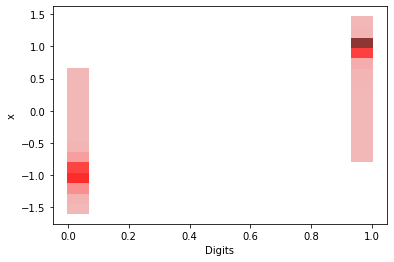

In [27]:
#Histogram of the first classifier
sns.histplot(df,x="Digits",y="x",color = 'red')


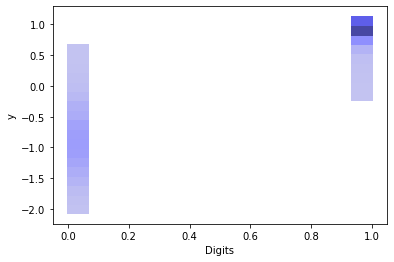

In [28]:
#Histogram of the second classifier 
sns.histplot(df,x="Digits",y="y",color = 'navy')

### **Part d:** Discussion of Results

Compare the classification performance of the least squares classifiers trained using the full data set ($X$) and the projection onto the PC space ($Z$):

* How do the accuracies of these two classifiers compare? Which is most accurate?

* Is there a meaningful/significant value in using the full data set $X$ (versus the reduced set $Z$)? What are the advantages of using $Z$?

* The accuracy of the first regression model is 99.479 % which is better than the 98.942 % accuracy of the second regression model (PCA). The histogram shows that the first regression model outperforms the PCA model specially for classifying zeros.
* Although using PCA would reduce accuracy slightly, it has plenty of advantages such as:
 * reducing the diminesion of data so less memory required to store the data 
 * visualizing the data so we can have a better understanding of data
 * reducing the computing time of algorithms used for classifying
 * giving acceptable accuracy for predicting the training data.

# Validating the Model using Testing Data

It is important to test if our classifiers can successfully predict digits from images that we haven't seen yet. There is a significant chance of overfitting whenever using supervised learning methods. 

*Overfitting* occurs when the classifiers perform well when making predictions of the training data used to build the classifier, but perform relatively poorly when classifying data outside this set. In this case, the classifier is biased towards the training data set in the sense that it is too dependent on properties of that set, which don't generalize to data outside the set.

To verify that we are not overfitting to the training data, we need to validate our classifiers using *testing* or *out-of-sample* data. If we have similar classification performance (e.g., similar accuracy rates, confusion matrices) for both testing and training data we can be confident that we are *not* overfitting.

## Reading the Test Data 

We will use a second data set of 0 and 1 digits to test that our classifiers from above work well for data that we haven't used for training.

We can use the following code to create arrays **Xt** and **yt** containing the testing data observations and digit labels from the file **mnist01-test.csv**.

In [29]:
# Read from CSV into array
M = np.genfromtxt("mnist01-test.csv", delimiter=",", skip_header= True)

# Confirm read completed.
n, p = M.shape
print("Created MNIST array with %g rows (images) and %g columns (labels and pixel intensities)" %(n, p))

# Split labels and images.
yt = M[:,0] # labels.
Xt = M[:, 1:] # data matrix with images as row.
Xt = Xt[:, idx] # Drop same columns as in training data.

# Confirm X is the right size.
n, p = Xt.shape
print("Created reduced MNIST array with %g rows (images) and %g columns (only pixel intensities)" %(n, p))

# Delete M.
del M

Created MNIST array with 2115 rows (images) and 785 columns (labels and pixel intensities)
Created reduced MNIST array with 2115 rows (images) and 491 columns (only pixel intensities)


This generates a data containing $2115$ images stored as $491$-dimensional vectors as the rows of $X_t$ with labels stored in the entries of $y_t$. 

## **Problem 3:** Validation using Testing Data

### **Part a:** Make Out-of Sample Predictions

Use the two least squares classifers (one using $X$ and $Z$) calculated in Problem 1 to predict the label of each image stored in $X_t$.

**Hint:** You will need to project $X_t$ onto the span of the first two principal components of $X$ to make predictions using the LSC trained using $Z$. We'll call the matrix representing the testing data in the PC space $Z_t$.

In [30]:
# Get first 2 principal componenents.
Vt = ph.getPCs(Xt, 2)
# Project onto the PC space.
Zt = Xt.dot(Vt)

### **Part b:** Scatterplots of Out-of-Sample Digits

Make scatter plots of the testing data in the two-dimensional PC space using the actual labels to assign marker shapes and the predicted labels given by:

*  the predicted labels using the least squares classifier calculated using $X$.

*  the predicted labels using the least squares classifier calculated using $Z$.

(This will yield two scatterplots as in our validation using the training data.)

In [31]:
y_st=yt.copy()
for i in range(len(y_st)):
  if y_st[i]==0:
    y_st[i]=-1
beta_Xt,v_Xt=ph.lsRegression(Xt,y_st)
beta_Zt,v_Zt=ph.lsRegression(Zt,y_st)

In [32]:
f_1t,y_1t=ph.lscPreds(Xt,beta_Xt,v_Xt)
f_2t,y_2t=ph.lscPreds(Zt,beta_Zt,v_Zt)

In [33]:
#transfrming -1,1 labels to 0,1:
for i in range(len(f_1t)):
  if f_1t[i]==-1:
    f_1t[i]=0
  if f_2t[i]==-1:
    f_2t[i]=0  

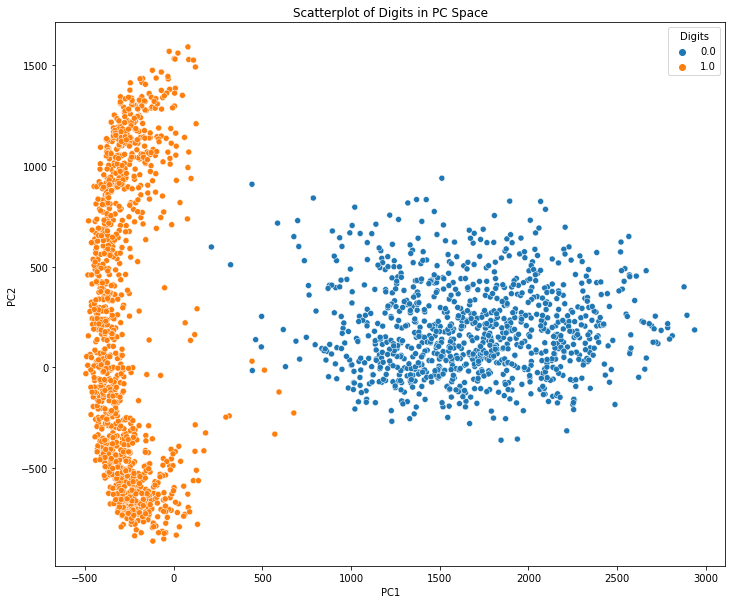

In [34]:
import matplotlib.pyplot as plt
# Import seaborn and pandas.
import seaborn as sns
import pandas as pd

# Create dictionary/data frame storing the data in the PC space (with labels).
data = {"x": Zt[:,0],
        "y": Zt[:,1],
        "Digits": yt}

df = pd.DataFrame(data)

plt.figure(figsize=(12,10))
sns.scatterplot(data = df, x = "x", y = "y", 
                hue="Digits")
plt.title("Scatterplot of Digits in PC Space")                
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

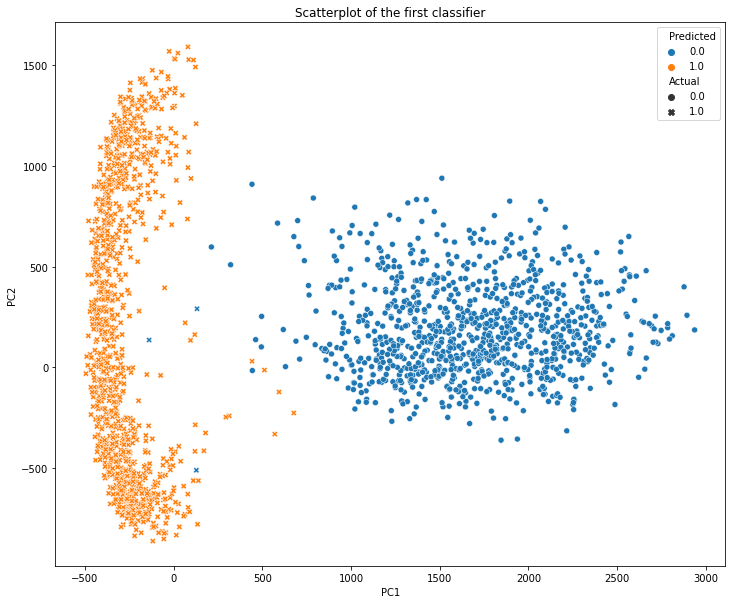

In [35]:
import matplotlib.pyplot as plt
# Import seaborn and pandas.
import seaborn as sns
import pandas as pd

# Create dictionary/data frame storing the data in the PC space (with labels).
data = {"x": Zt[:,0],
        "y": Zt[:,1],
        "Actual": yt,
        "Predicted":f_1t}

df = pd.DataFrame(data)
plt.figure(figsize=(12,10))
sns.scatterplot(data = df, x = "x", y = "y", 
                hue="Predicted",style="Actual")
plt.title("Scatterplot of the first classifier")                
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

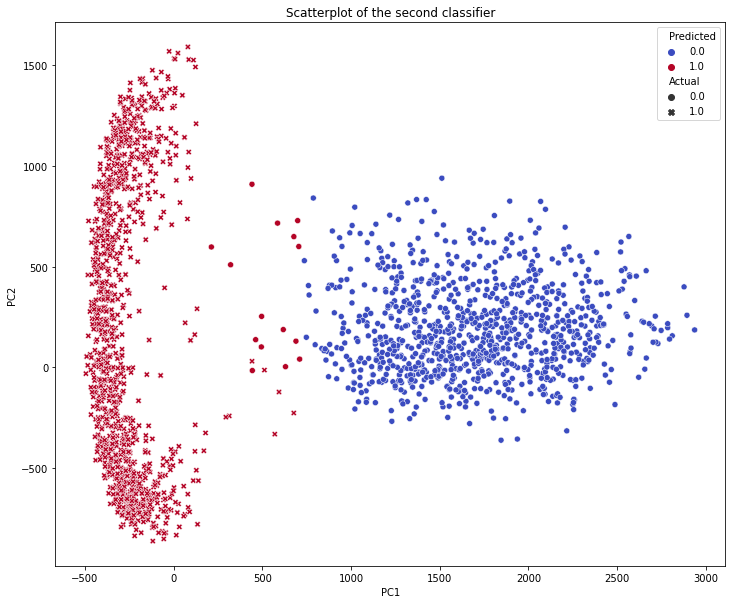

In [36]:
# Import seaborn and pandas.
import seaborn as sns
import pandas as pd

# Create dictionary/data frame storing the data in the PC space (with labels).
data = {"x": Zt[:,0],
        "y": Zt[:,1],
        "Predicted": f_2t,
        "Actual":yt}

df = pd.DataFrame(data)

plt.figure(figsize=(12,10))
sns.scatterplot(data = df, x = "x", y = "y", 
                hue="Predicted",
                hue_norm=(0,1),
                style = "Actual",
                palette="coolwarm")
plt.title("Scatterplot of the second classifier")                
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

### **Part c:** Out-of-Sample Confusion Matrices

* Make confusion matrices for the test data predictions made using the LSC created using $X$ and $Z$.

* Visualize the confusion matrices as heat maps as in Problem 2.

* Report the total number of correctly and incorrectly labeled test images and the overall out-of-sample accuracy rate of the two classifiers.

In [37]:
conf1t=conf(f_1t,yt)
conf2t=conf(f_2t,yt)


[Text(83.40000000000006, 0.5, 'Predicted labels'),
 Text(0.5, 15.0, 'Actual labels')]

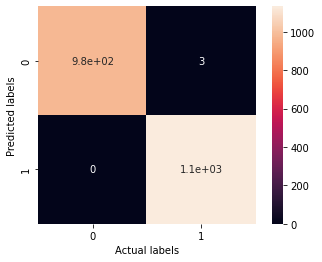

In [38]:
from seaborn import heatmap
s=heatmap(conf1t,square=True, cbar=True,annot=True)
s.set(xlabel='Actual labels', ylabel='Predicted labels')

[Text(83.40000000000006, 0.5, 'Predicted labels'),
 Text(0.5, 15.0, 'Actual labels')]

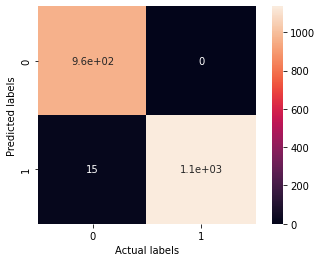

In [39]:
from seaborn import heatmap
s=heatmap(conf2t,square=True, cbar=True,annot=True)
s.set(xlabel='Actual labels', ylabel='Predicted labels')

In [40]:
print("The first classifier predits the label of %1.0f items correctly which consists %1.3f percent of the test data." %( conf1t[0,0]+conf1t[1,1] ,(conf1t[0,0]+conf1t[1,1])/sum(sum(conf1t))*100 ))

The first classifier predits the label of 2112 items correctly which consists 99.858 percent of the test data.


In [41]:
print("The second classifier predits the label of %1.0f items correctly which consists %1.3f percent of the test data." %( conf2t[0,0]+conf2t[1,1] ,(conf2t[0,0]+conf2t[1,1])/sum(sum(conf2t))*100 ))

The second classifier predits the label of 2100 items correctly which consists 99.291 percent of the test data.


### **Part d:** Histograms of Out-of-Sample Predictions

Make histograms of the predicted values of the two least squares models (i.e., the values $X_t \beta + v$ and $Z_t \hat\beta + \hat v$).

In [42]:
data = {"x": Xt.dot(beta_Xt)+v_Xt,
        "y": Zt.dot(beta_Zt)+v_Zt,
        "Digits": yt}

df = pd.DataFrame(data)

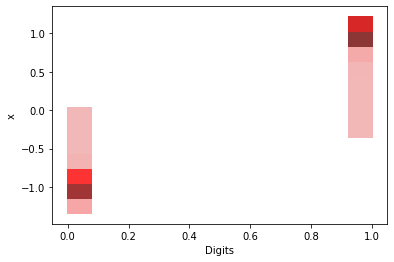

In [43]:
sns.histplot(df,x="Digits",y="x",color = 'red')


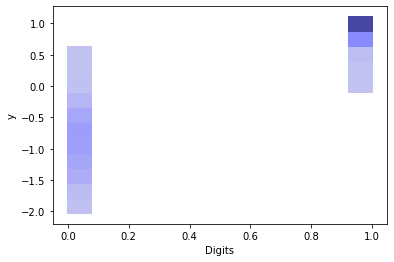

In [44]:
sns.histplot(df,x="Digits",y="y",color = 'navy')

### **Part e:** Interpreting the Plots

Compare the classification accuracy and plots for the training and testing data:

* Do the classifiers perform similarly for the two data sets?

* Do you think overfitting has occured?

The first classifier predicts 99.858 % of items correctly versus the second classifier which shows 99.291 % accuracy. Since both accuracies are very high for the two classifiers I do not think overfitting accurs here. Both model perform accurate on the test data set. 